# Quantum K-Nearest Neighbors: Utilizing QRAM and SWAP-Test Techniques for Enhanced Performance


## Classical algorithm

The classical K-NN classification algorithm, extensively utilized in supervised learning, relies on two datasets: a training set containing labeled samples and a test set consisting of unlabeled ones. To classify each test sample, the algorithm employs a similarity metric, typically a distance metric in feature space.


the classical algorithm is shown as an image and pseudocode:


<div style="background-color:#E2E2E2; padding:10px 0;font-family:monospace;">
<font color = "blue"><b>Classical K-NN</b></font><br>
    &nbsp;&nbsp;&nbsp;&nbsp; Designate a labeled training set and an unlabeled test set. <br> 
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the test set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the training set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Compute the distance between the test event and training event.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Find the K nearest neighbors to the test event.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; The class with the highest number of nearest neighbors is assigned to the test event.<br>
</div>

<img src="images/qknn_figure1.png" alt="example of K-NN" style=" height: 233px; width:621px;  display: block; margin-left: auto;   margin-right: auto;"  />

## Quantum proposal

### Dependencies 


This quantum algorithm uses qiskit, numpy, skelearn  and seaborn as dependencies to run the cide.

In [1]:
# import sklearn to load the iris dataset and split the dataset in train and test model, and the metric confusion matrix
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import pandas to use seaborn plots as hue parameter
import pandas as pd

# import seaborn to plot the iris dataset
import seaborn as sns

# import numpy for postprocessing to find the k-nn label
import numpy as np

#module to find the mode
import operator

# import math methods
import math

#save data
import pickle

# import qiskit minimal methods to use quantum circuit and use qubits as the classical bits
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import CircuitInstruction, Instruction
from qiskit.circuit.library.standard_gates import CRYGate,RYGate,RZGate

#progress bar
from tqdm import tqdm

# Dataset

Obtained  iris dataset from sklearn using dataset module. The iris dataset is used, which has 3 classes: **Iris-setosa**,**Iris-versicolor**,**Iris-virginica**, each with 50 instances, resulting in a total of 150.


In [2]:
iris = datasets.load_iris()

This dataset plot using Seaborn module, a dataframe is required to read the variables, denoted as 'var1', 'var2', 'var3', and 'var4', along with the 'class' for color differentiation. Additionally, the chosen color palette is 'Paired'. 

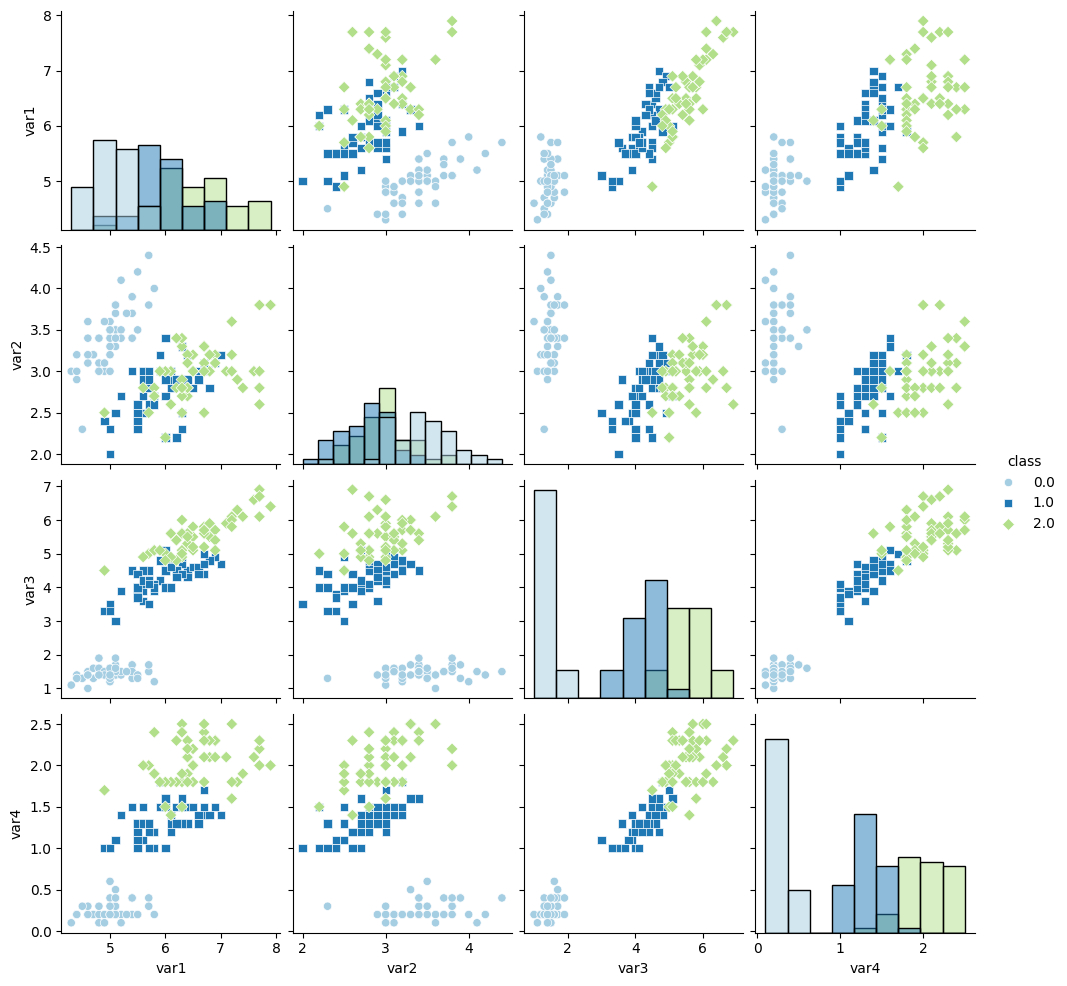

In [3]:
df_iris = pd.DataFrame(np.append(iris['data'],np.atleast_2d(iris['target']).T, axis=1))
df_iris.columns =['var1', 'var2', 'var3', 'var4',"class"]
sns.pairplot(df_iris,hue="class", diag_kind="hist", markers=["o", "s", "D"], palette="Paired")

The hold-out method is used, with a split of 70% for the training set and 30% for the test set.

In [4]:
x_train, x_test, y_train, y_test =train_test_split(iris['data'], iris['target'], train_size=0.7, test_size=0.3, random_state=13)

In [5]:
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 105
Number of original test examples: 45


# The quantum algorithm

The QK-NN is based on three critical components: data storage in QRAM, the similarity metric from the SWAP-Test quantum circuit, and grouping both of those to allow Grover's algorithm to increase the probability of selecting states with higher similarity as shown in the following Pseudocode and Figure

<div style="background-color:#E2E2E2; padding:10px 0;font-family:monospace;">
<font color = "blue"><b>Quantum K-NN</b></font><br>
    &nbsp;&nbsp;&nbsp;&nbsp; Designate a labeled training set and an unlabeled test set.<br> 
    &nbsp;&nbsp;&nbsp;&nbsp; Apply angle encoding to the features of both datasets <br> 
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the test set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Load the training set into QRAM. <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Initialize the oracle qubit to the state $|-\rangle$ <br>
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; The class with the highest number of nearest neighbors is assigned to the test event.<br>
</div>

<img src="images/qknn_figure7.png">

#### initial variables for  a example

In [6]:
# size of the QRAM with 4 cells |00>, |01>, |10>, |11>
size_QRAM = 2

# lenght of the feautres of the QRAM
features = len(x_train[0])

##### Integer to binary

The first method using is generate a function to convert a integer value i na bin representation to qiskit, this  works to generate the control qubits needed for the QRAM

In [7]:
def index_positions(value:int = 0):
    """
    Convert an integer value into binary representation, then flip the digits
    into Qiskit qubit ordering convention. So, e.g.,

    4 -> 0b100 -> |q0 q1 q2> -> [0,0,1] -> returns [2]

    Args:
        value: integer value that we transform in binary number that representate in a list position

    Returns:
        list: a integer list of position that representate the index position of ones in a binary number
    """
    list_bin = []
    temp = bin(value)[2:]
    temp = temp[::-1]
    for i, v in enumerate(temp):
        if v == '1':
            list_bin.append(i)
    return list_bin

For example, the number 4 convert in 100, but the index position in a QRAM is 2 for the format q0q1q2, where q2 is  the position.

In [8]:
index_positions(4)

[2]

#### The diffuser

Is a quantum circuit used in Grover's algorithm that do a reflection operation to consider in this algorithm only the train state more similar with  the test set's instance

In [9]:
def diffuser(nqubits:int = 2):
    """
    Construct the Grover diffuser gate for `nqubits` qubits.

    Args:
        nqubits: integer value that indicate the number of qubits to build the diffuser gate

    Returns:
        qiskit.circuit.gate.Gate: a quantum gate with the label of diffuser
    """
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Return the diffuser as a gate
    u_gate = qc.to_gate()
    u_gate.name = "$diffuser$"
    return u_gate

For example a diffuser of 3 qubits where using a mcx gate changed to mcz  with the equivalence HXH = Z.

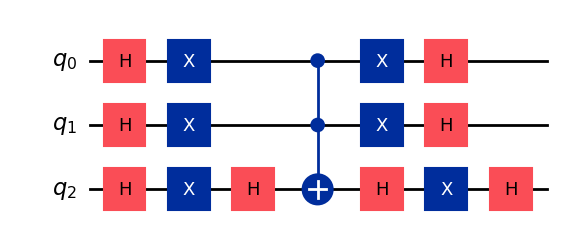

In [10]:
nqubits = 3
def example_diffuser(nqubits:int):
    qc_d = QuantumCircuit(nqubits)
    qc_d.append(diffuser(nqubits),range(nqubits))
    return qc_d
example_diffuser(nqubits).decompose().draw("mpl")

#### The QRAM and QRAM$^{\dagger}$ 


This is a method using a MCX to save the train set, the size must be $2^m$, $m$ is the number of qubits address. a And save the information in $n$ qubits features· 

In [11]:
def qram(
        size_QRAM:int = 1,
        features:int = 1,
        train_set:list = [],
        gate:Instruction = RYGate
    ):  # pylint: disable=invalid-name,dangerous-default-value
    """
    Build a QRAM with CRY or H-CRZ gates.

    Args:
        size_QRAM: integer value that indicate the address qubits
        features: integer value  of the number of rotations gates to save in the QRAM
        train_set: list of the train set

    Returns:
        qiskit.circuit.quantumcircuit.QuantumCircuit: a QRAM that has the dataset
        encoded through RZ or RY gates.
    """
    address = QuantumRegister(size_QRAM, name = "address qubits")
    ancilla = QuantumRegister(1, name = "ancilla qubit")
    data = QuantumRegister(features, name = "train data qubits")
    qc = QuantumCircuit(address, ancilla, data)

    len_arr = 2**size_QRAM

    # cap array length to be the length of the trainings set
    if len_arr > len(train_set):
        len_arr = len(train_set)

    for i in range(len_arr):
        x_gates_array = index_positions(i)
        if x_gates_array:
            qc.x(address[x_gates_array])
        qc.mcx(address,ancilla)
        angles = train_set[i]
        for index, value in enumerate(angles):
            qc._append(CircuitInstruction(gate(value).control(),[ancilla[0],data[index]]))
        qc.mcx(address,ancilla)
        if x_gates_array:
            qc.x(address[x_gates_array])
        qc.barrier()

    return qc

For example a QRAM of 2 qubits address and the first four elements of iris train set.

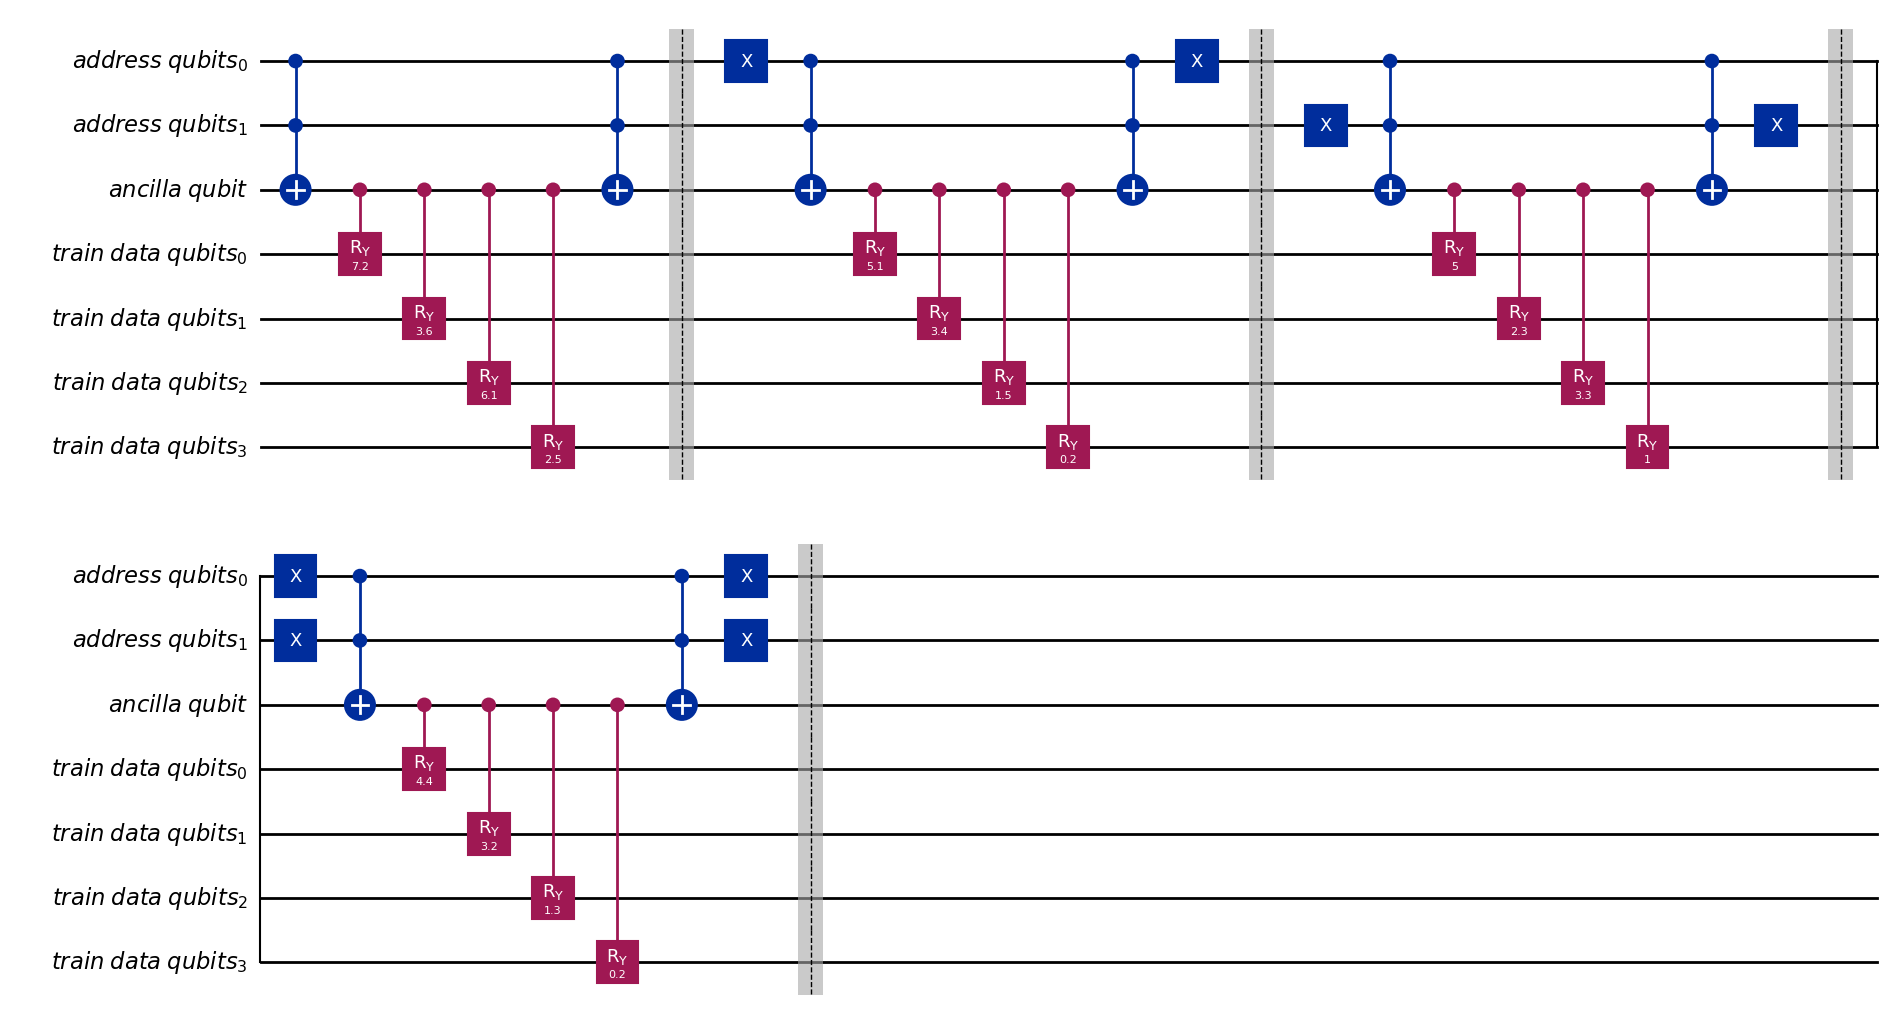

In [12]:
qram(size_QRAM,features,x_train[:4],RYGate).draw("mpl")

For example a QRAM$^{\dagger}$ of 2 qubits address and the first four elements of iris train set using the qiskit method **inverse()**.

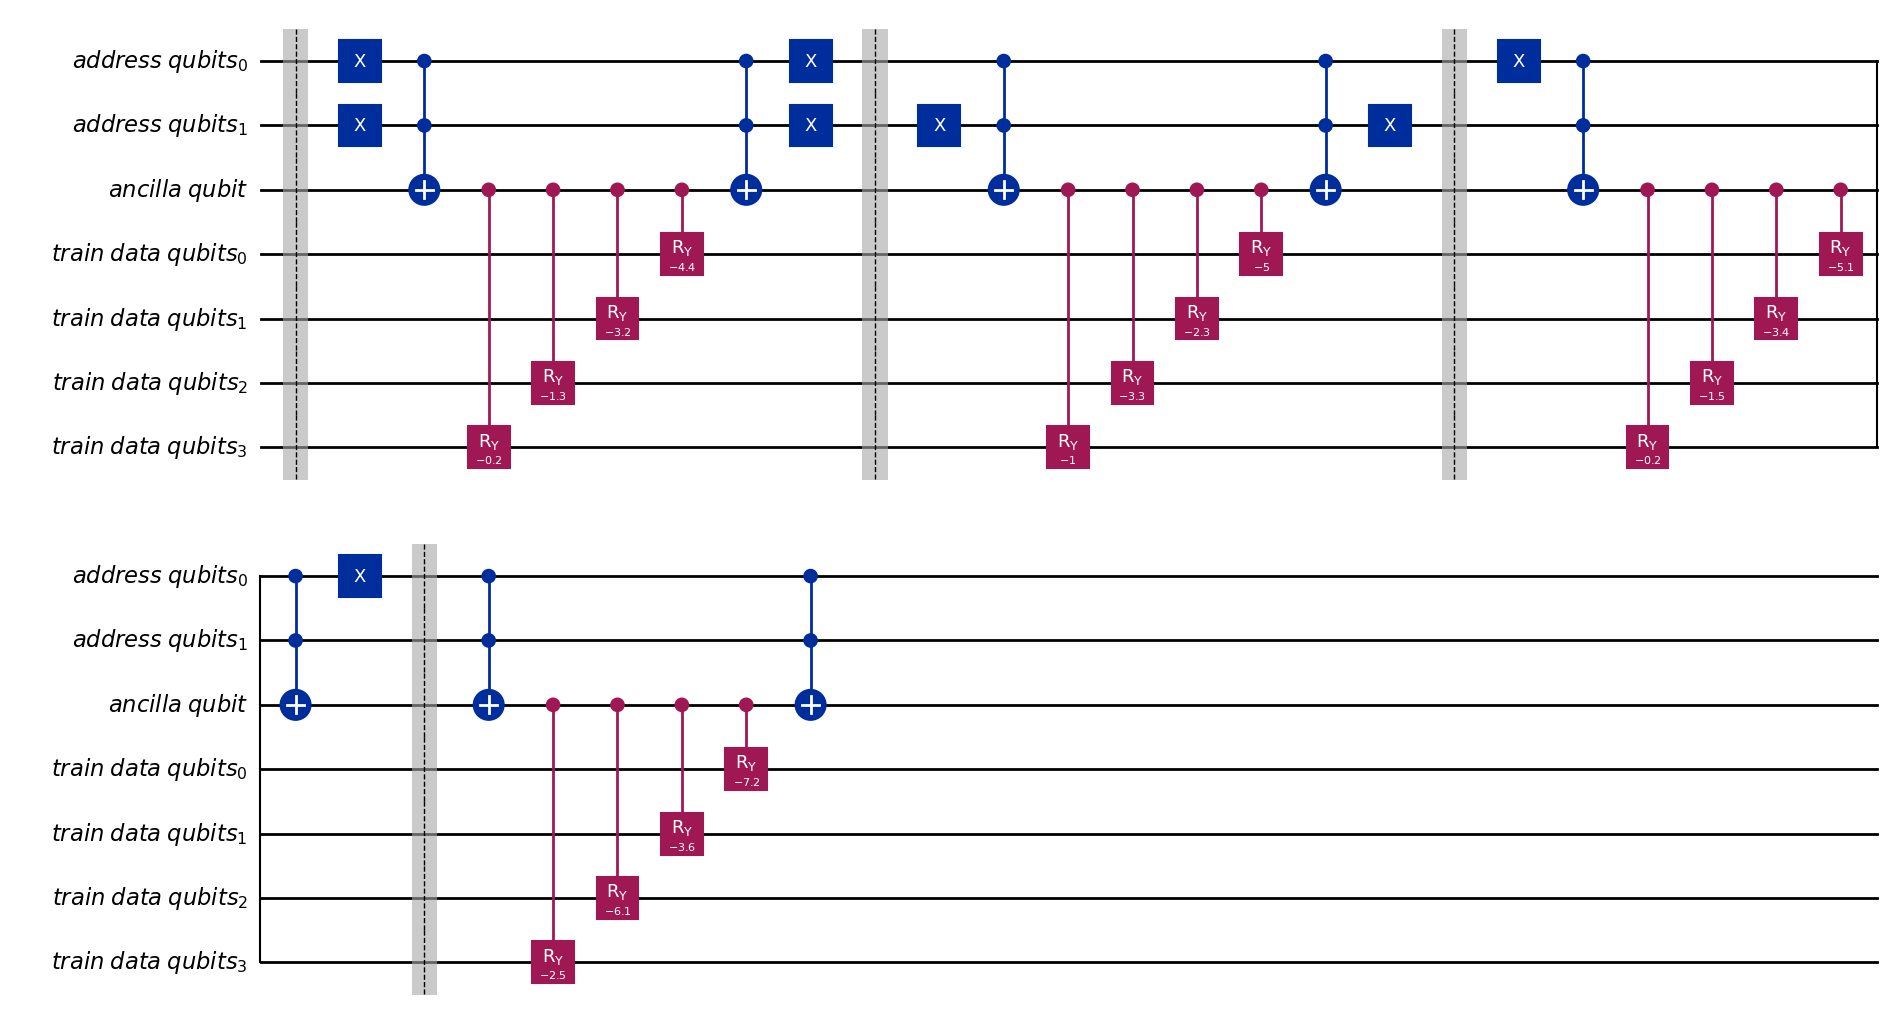

In [13]:
qram(size_QRAM,features,x_train[:4]).inverse().draw("mpl")

#### Oracle


Describes the oracle to check the similar state between the train set and the instance of the test set

In [14]:
def oracle_st(features:int, test_value:list,gate:Instruction=RYGate):
    """
    Build a Oracle using SWAP-Test.

    Args:
        features: integer value  of the number of rotations gates to comparate in the SWAP-Test
        test_value: list of an instance of the test set

    Returns:
        qiskit.circuit.quantumcircuit.QuantumCircuit: a SWAP-Test with a mid measurement to
        comparate with two state of size features.
    """
    data_train = QuantumRegister(features,name = "train data qubits")
    data_test = QuantumRegister(features,name = "test data qubits")
    swap_test = QuantumRegister(1, name = "SWAP-Test qubit")
    oracle = QuantumRegister(1, name = "oracle qubit")
    c_oracle = ClassicalRegister(1, name = "mid measure")
    qc = QuantumCircuit(data_train,data_test,swap_test,oracle,c_oracle)

    qc.h(swap_test)

    #if gate == RZGate: 
    #    qc.h(data_test)
    
    for i in range(features):
        qc._append(CircuitInstruction(gate(test_value[i]),[data_test[i]]))
        qc.cswap(swap_test,data_train[i],data_test[i])
    qc.h(swap_test)
    qc.barrier()

    qc.measure(swap_test,c_oracle)
    qc.x(oracle).c_if(c_oracle[0], 0)
    qc.barrier()


    for i in range(features):
        qc._append(CircuitInstruction(gate(-test_value[i]),[data_test[i]]))
    qc.barrier()

    #if gate == RZGate: 
    #    qc.h(data_test)

    return qc

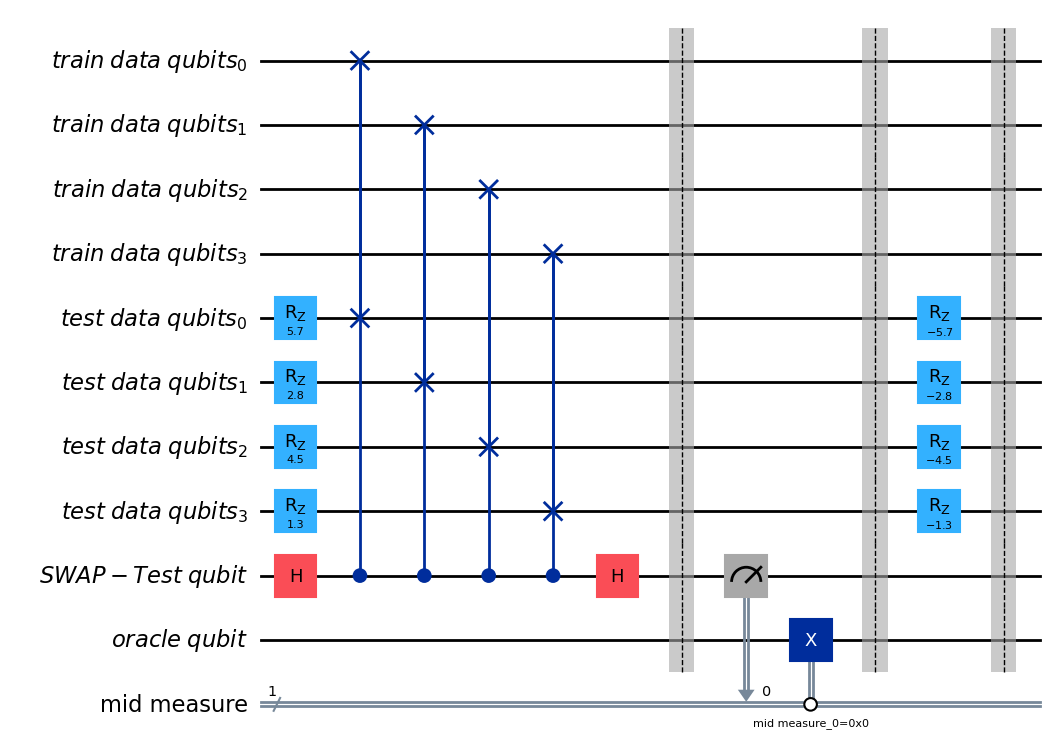

In [15]:
oracle_st(features,x_test[0],RZGate).draw("mpl")

#### Integrate all in a QK-NN quantum circuit

Using the previous function and the diagram to design the Quantum Circuit added the SWAP-Test with intermediate measurement that is activate when is the value 0.

In [16]:
def qknn(
        test_value:list,
        train_set:list,
        size_QRAM:int,
        features:int,
        max_trials:int=1000,
        rotation:str="ry" 
    ):  # pylint: disable=invalid-name
    """
    Build a QKNN.

    Args:
        test_value: list of an instance of the test set
        train_set: list of the train set
        size_QRAM: integer value that indicate the address qubits
        features: integer value  of the number of rotations gates to save in the QRAM
        max_trials: integer number to repeat the oracle and diffuser follows the
        Grover's algorithm format

    Returns:
        qiskit.circuit.quantumcircuit.QuantumCircuit: a QKNN circuit for a comparition of
        a particular test set instance with a sample or all the train set
    """
    # TODO: add a flag to choose rotation gates
    # TODO: remove unused arguments
    # TODO: fix for "arbitrary" (somewhat) input data - at least remove as much hardcoding as possible
    n = 2**size_QRAM
    n_grover_trials = math.ceil(math.sqrt(n))
    if max_trials:
        n_grover_trials = min(max_trials, n_grover_trials)


    rotation_gates = {"ry": RYGate, "rz": RZGate}


    gate = rotation_gates[rotation]

    address = QuantumRegister(size_QRAM,name = "address qubits")
    ancilla = QuantumRegister(1,name = "ancilla qubits")
    data_train = QuantumRegister(features,name = "train data qubits")
    data_test = QuantumRegister(features,name = "test data qubits")
    swap_test = QuantumRegister(1,name = "SWAP-Test qubit")
    oracle = QuantumRegister(1,name = "Oracle qubit")
    c = ClassicalRegister(size_QRAM,name = "address bits")
    c_oracle = ClassicalRegister(1,name = "oracle bit")
    qc = QuantumCircuit(address, ancilla, data_train, data_test, swap_test,oracle, c,c_oracle)

    qc.h(address)
    qc.x(oracle)
    qc.h(oracle)



    qc.barrier()

    for _ in range(n_grover_trials):

        if gate == RZGate: 
            qc.h(data_train)
            qc.h(data_test)
        qc.append(qram(size_QRAM,features,train_set,gate),
                  address[:] + ancilla[:] + data_train[:])
        qc.append(oracle_st(features,test_value,gate),
                  data_train[:] + data_test[:] + swap_test[:] + oracle[:],
                  c_oracle[:])
        qc.append(qram(size_QRAM,features,train_set,gate).inverse(),
                  address[:] + ancilla[:] + data_train[:])
        qc.append(diffuser(size_QRAM),address)
        qc.barrier()


        if gate == RZGate: 
            qc.h(data_train)
            qc.h(data_test)

    qc.x(address)
    qc.measure(address,c)

    return qc


Example with 2 qubits of the QK-NN of the first 4 features.

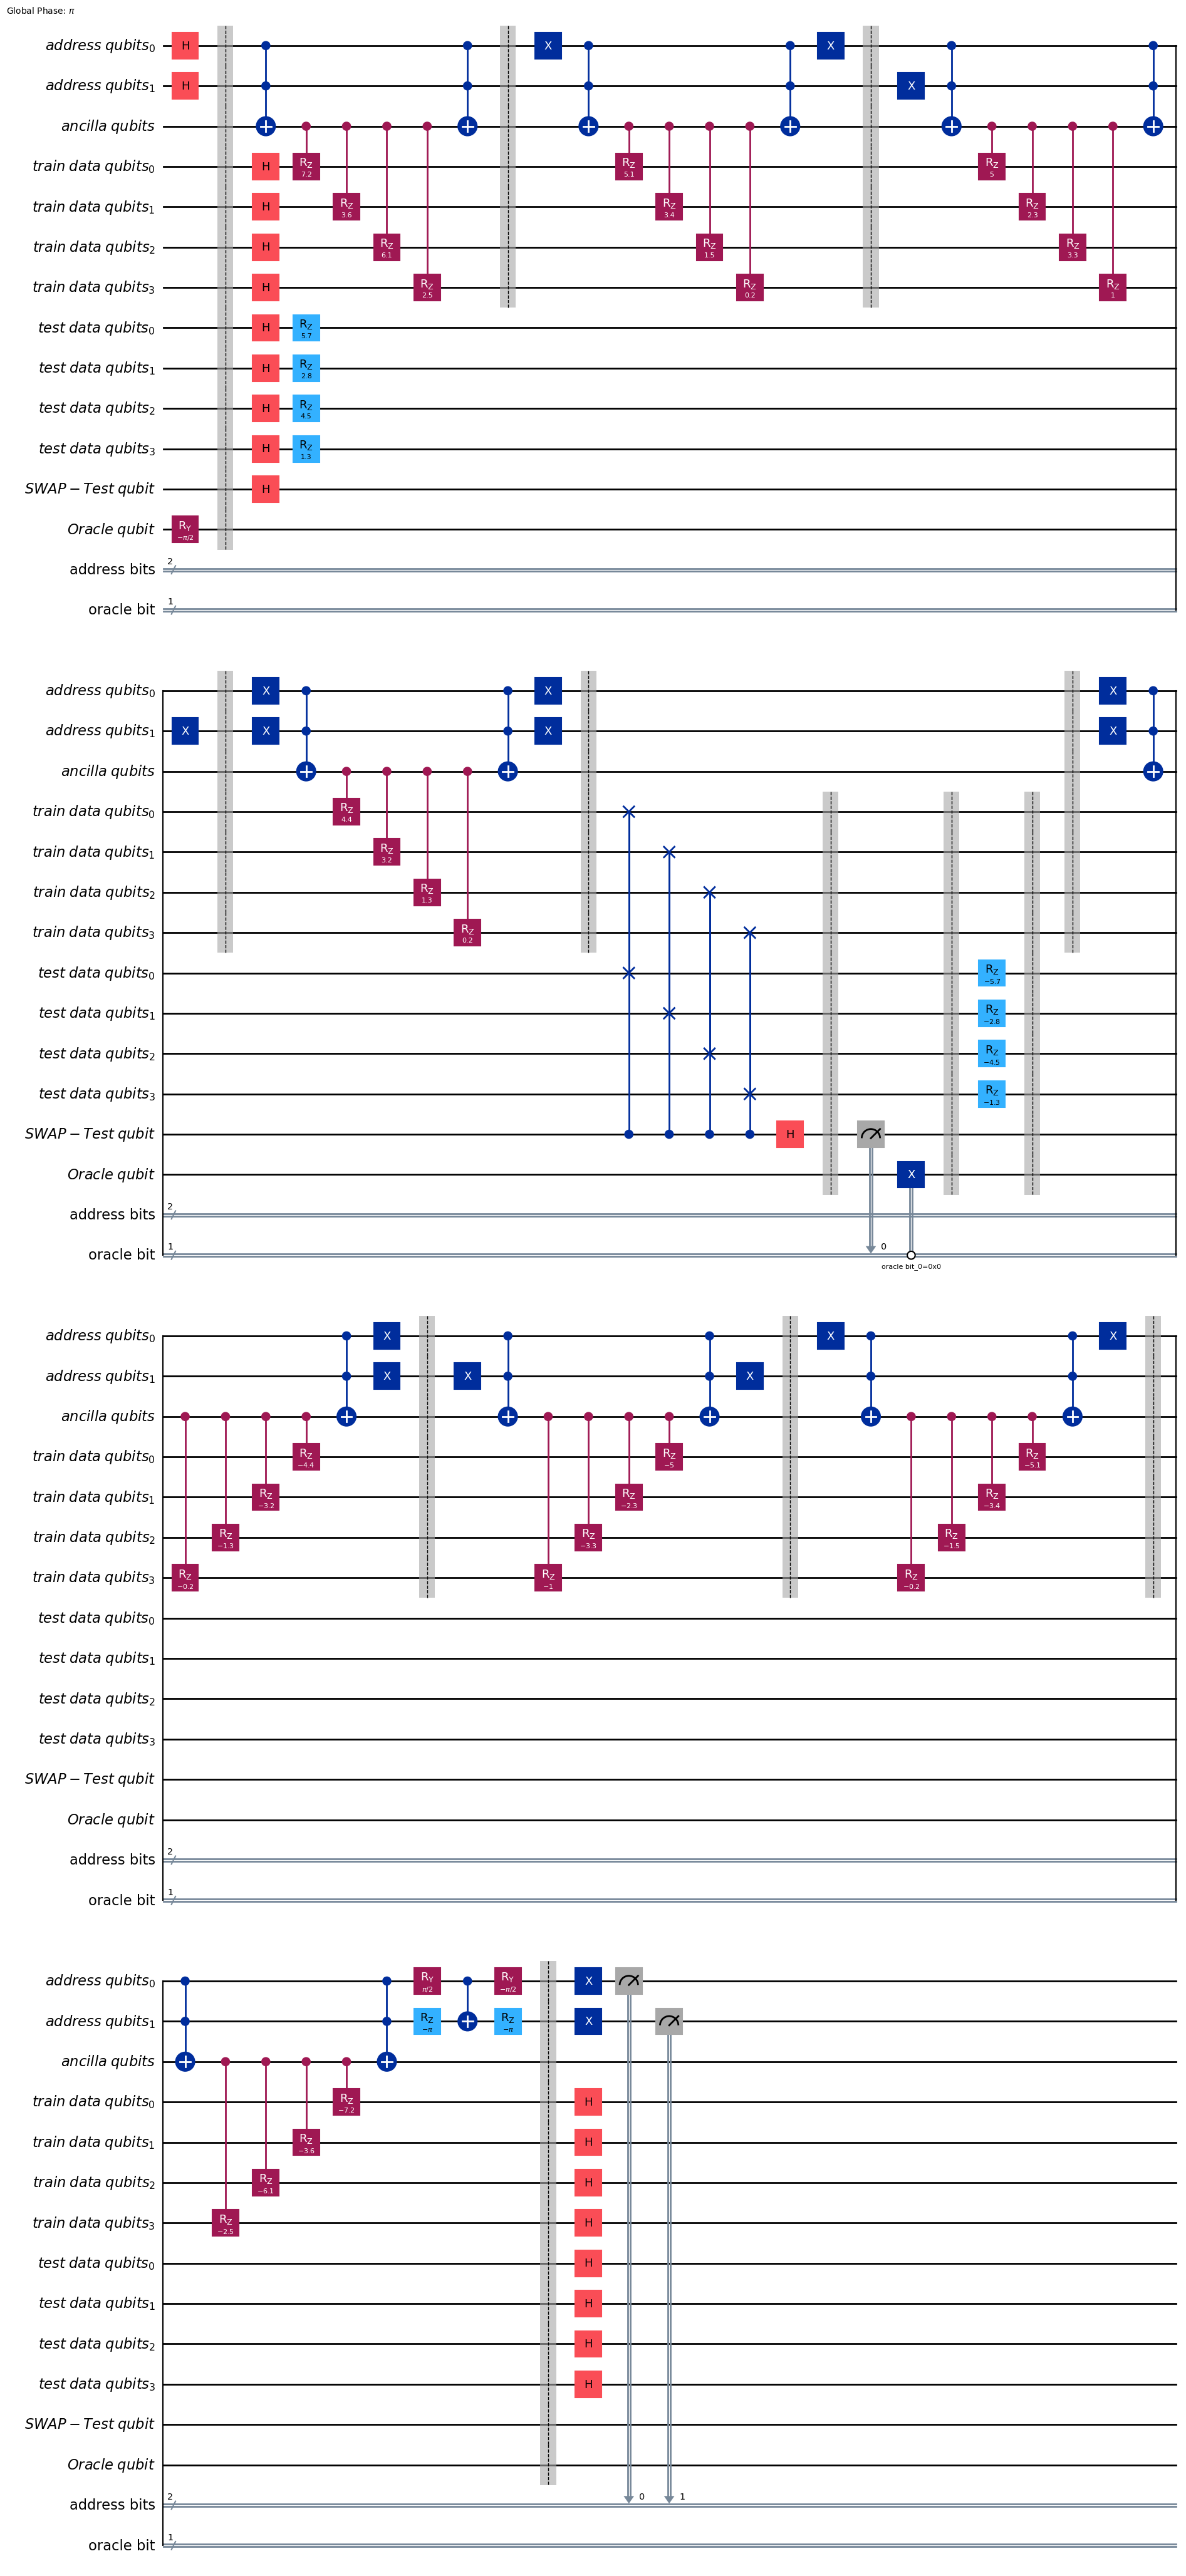

In [17]:
max_trials = 1
transpile(qknn(x_test[0], x_train,size_QRAM,features,max_trials,"rz"), basis_gates=[ 'cswap','cry','crz', 'barrier', 'h', 'measure', 'ccx', 'x', 'reset', 'rz', 'ry', 'snapshot', 'cx', 'delay']).draw("mpl")

### Experiments

Experiments of the QK-NN with size of QRAM of 8, 16, 32, 64, and 128 cells of memory.

In [18]:
class qknn_experiments():
    """
    Class to use multiple knn experiments
    """
    
    def __init__(self,x_test:list=[[1]],
                    x_train:list=[[1]],
                    y_test:list=[[1]],
                    features:int=1,
                    max_trials:int=1,
                    rotation:str="ry",
                    experiment_size:int=1,
                   min_QRAM:int=3,
                    max_QRAM:int=4):
        self.x_test = x_test
        self.x_train = x_train
        self.y_test = y_test
        self.features = features
        self.max_trials = max_trials
        self.rotation = rotation
        self.experiment_size = experiment_size
        self.min_QRAM = min_QRAM
        self.max_QRAM = max_QRAM
        self.size_test_set = len(y_test)

        self.acc_8 = []
        self.acc_16 = []
        self.acc_32 = []
        self.acc_64 = []
        self.acc_128 = []


    def experiments_1nn(self,shots:int =10000):
        for _ in tqdm(range(self.experiment_size)):
            for size in range(self.min_QRAM,self.max_QRAM):
                result_lista = []
                y_pred = []
                counts_l = []
                
                for i in range(self.size_test_set):
                    qc = qknn(self.x_test[i], self.x_train,size,self.features,self.max_trials,self.rotation)
                    result = AerSimulator().run(transpile(qc,basis_gates=["cx","rz","x","sx"]), shots=shots).result()
                    counts = result.get_counts(qc)
                    counts_l.append(counts)
                    output = '0'
                    while output[0] != '1':
                        output = max(counts.items(), key=operator.itemgetter(1))[0]
                        del counts[output]
                    y_pred.append(y_train[int(output[1:], 2)])
                    result_lista.append([y_pred[i], self.y_test[i]])
        
                cf_matrix = confusion_matrix(y_test[:self.size_test_set], y_pred)
                acc_knn = ((cf_matrix[0][0]+cf_matrix[1][1]+cf_matrix[2][2])/sum(sum(cf_matrix)))*100
                
                if size == 3:
                    self.acc_8.append(acc_knn)
        
                elif size == 4:
                    self.acc_16.append(acc_knn)
        
                elif size == 5:
                    self.acc_32.append(acc_knn)
        
                elif size == 6:
                    self.acc_64.append(acc_knn)
                    
                elif size == 7:
                    self.acc_128.append(acc_knn)
        
    
        return self.acc_8,self.acc_16,self.acc_32,self.acc_64,self.acc_128


    def set_rotation(self,rotation:str="ry"):
        self.rotation = rotation
    
    def draw_qknn(self,index:int=0,size:int=3):
        return qknn(self.x_test[index], self.x_train,size,self.features,self.max_trials,self.rotation)

    
    def mae_acc(self,acc:list):
        mean =  np.mean(np.asarray(acc))
        n = len(acc)
        summ = 0
        for i in range(n):
            summ += abs(mean - acc[i])
        return mean,summ/n
    
    def print_results(self):
        print("The MAE value of each size is ")
        for i in range(self.min_QRAM,self.max_QRAM):
            mean,error = 0,0
            if i == 3:
                mean,error  = self.mae_acc(self.acc_8)
            elif i == 4:
                mean,error  = self.mae_acc(self.acc_16)
            elif i == 5:
                mean,error  = self.mae_acc(self.acc_32)
            elif i == 6:
                mean,error  = self.mae_acc(self.acc_64)
            elif i == 7:
                mean,error  = self.mae_acc(self.acc_128)
                
            print(f'MAE of  QRAM of size {int(2**i)} cells of memory with {mean:.2f} +/- {error:.2f}.')


###  Results

#### RY

In [19]:
experiment_size = 10
min_QRAM = 3
max_QRAM = 5
qknn_e = qknn_experiments(x_test=x_test,x_train=x_train,y_test=y_test,features=4,max_trials=1,rotation="ry",experiment_size=experiment_size)

100%|███████████████████████████████████████████| 10/10 [01:24<00:00,  8.46s/it]


The MAE value of each size is 
MAE of  QRAM of size 8 cells of memory with 82.89 +/- 0.93.


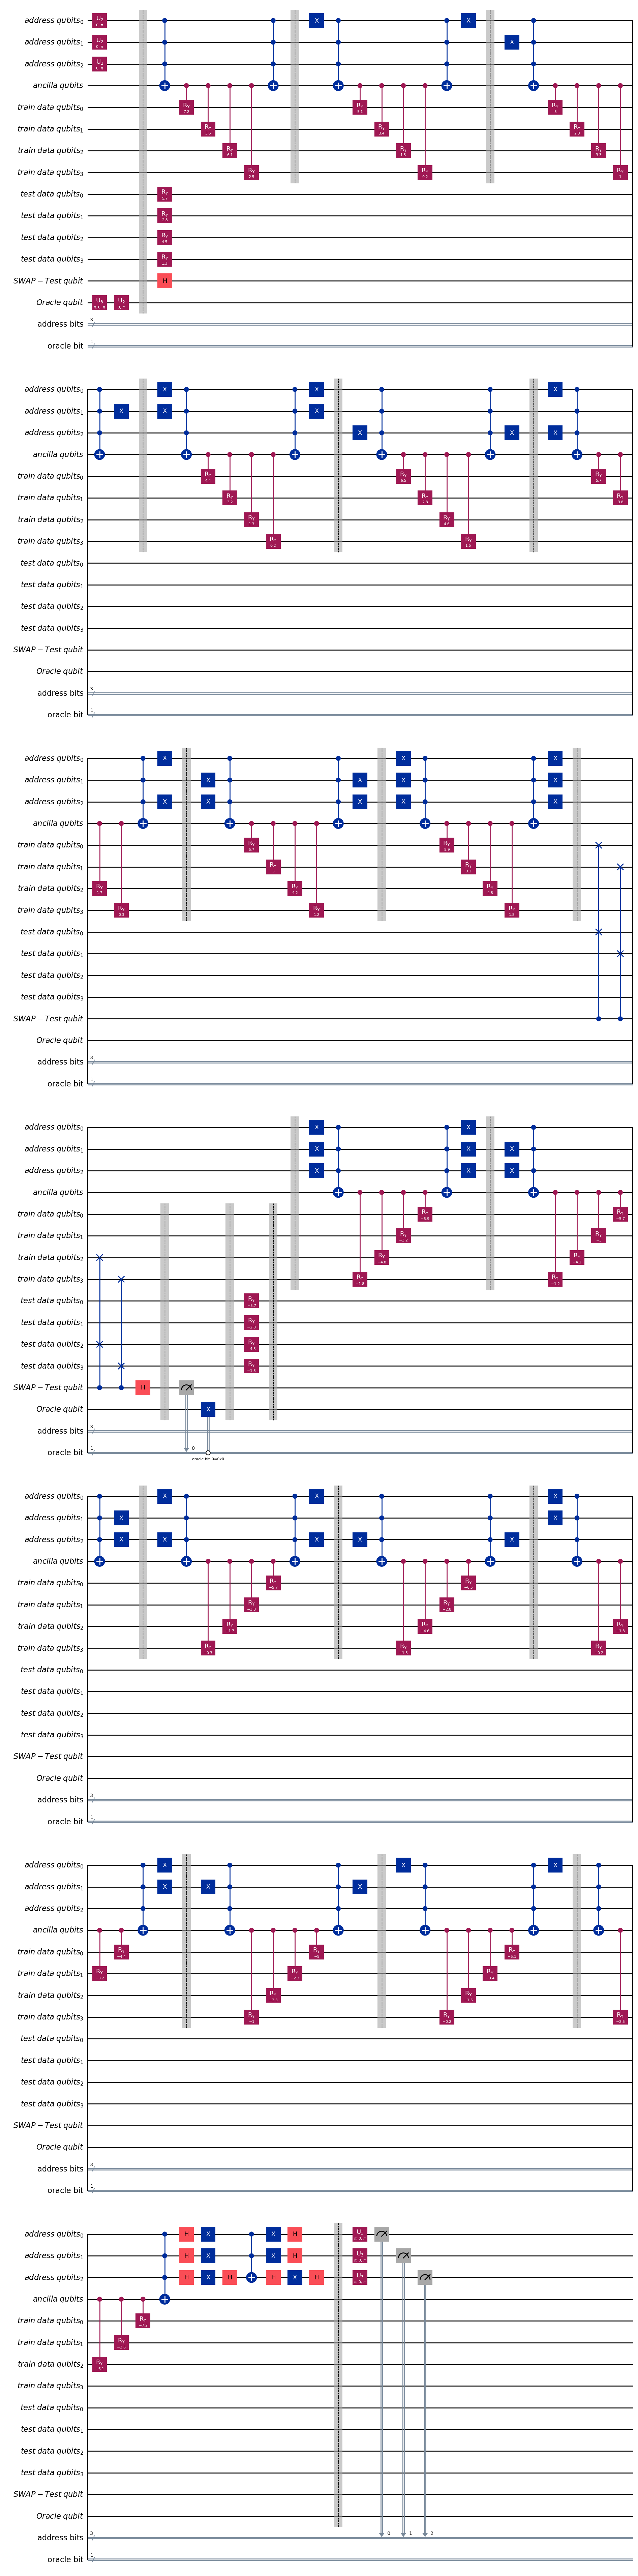

In [20]:
qknn_e.experiments_1nn()
qknn_e.print_results()
qknn_e.draw_qknn(0).decompose().draw("mpl")

100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.32s/it]


The MAE value of each size is 
MAE of  QRAM of size 8 cells of memory with 83.11 +/- 1.16.


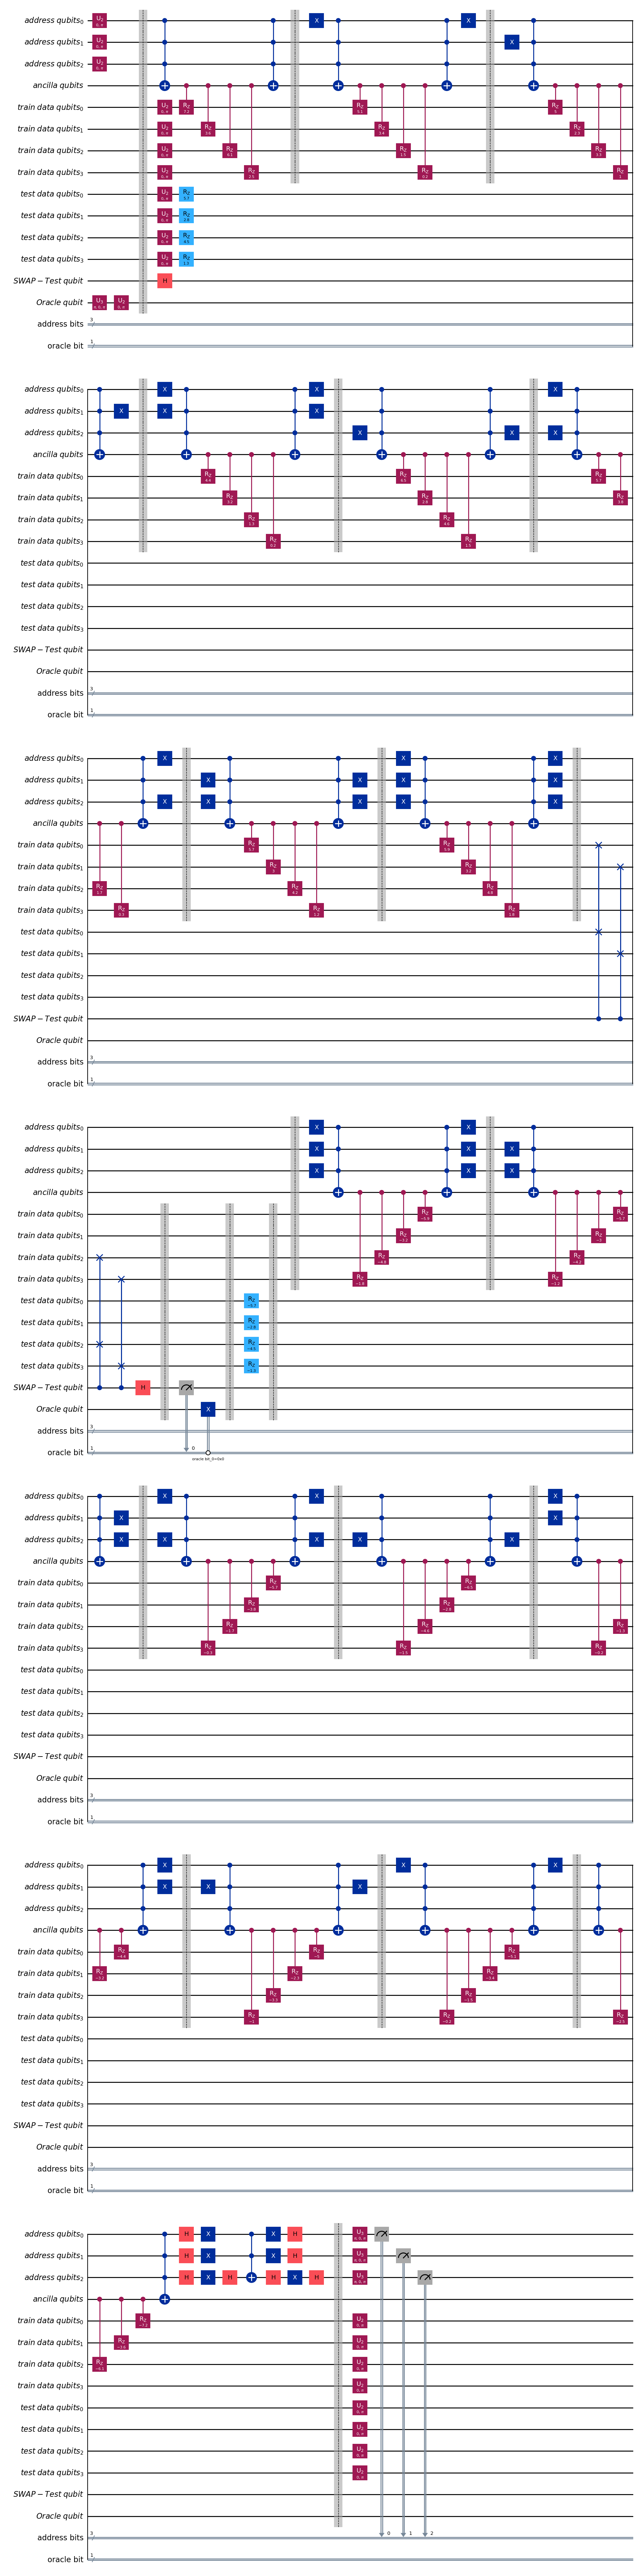

In [21]:
qknn_e.set_rotation("rz")
qknn_e.experiments_1nn()
qknn_e.print_results()
qknn_e.draw_qknn(0).decompose().draw("mpl")